In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import random
from copy import deepcopy
import time
import IPython.display as display
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
def load_img(img_path):
    max_dim = 256
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, axis=0)
    return img

In [3]:
content_path = 'content_image.jpg'
style_path = 'style_image.jpg'

In [4]:
def show_img(img, title=None):
    if isinstance(img, Image.Image):
        plt.imshow(img)
    else:
        if len(img.shape) > 3:
            img = tf.squeeze(img, axis=0)
        plt.imshow(img.numpy())
    if title:
        plt.title(title)
    plt.axis("off")

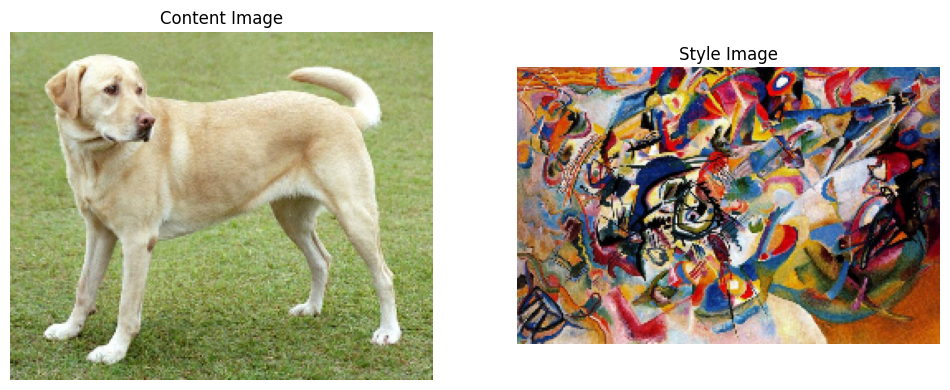

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
show_img(content_image, 'Content Image')
plt.subplot(1, 2, 2)
show_img(style_image, 'Style Image')
plt.show()

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = []
  for name in layer_names:
    layer = vgg.get_layer(name)
    outputs.append(layer.output)

  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
  return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [10]:
def gram_matrix(tensor):
    if len(tensor.shape) == 3:
        tensor = tf.expand_dims(tensor, 0)  # [1, H, W, C]

    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    num_locations = tf.cast(tf.shape(tensor)[1] * tf.shape(tensor)[2], tf.float32)
    return result / num_locations

In [11]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)

        self.vgg = vgg_layers(style_layers + content_layers)

    def preprocess(self, image):
        image = image * 255.0
        return tf.keras.applications.vgg19.preprocess_input(image)

    def extract_style(self, outputs):
        style_outputs = outputs[:self.num_style_layers]
        return {
            name: gram_matrix(output)
            for name, output in zip(self.style_layers, style_outputs)
        }

    def extract_content(self, outputs):
        content_outputs = outputs[self.num_style_layers:]
        return {
            name: output
            for name, output in zip(self.content_layers, content_outputs)
        }

    def call(self, inputs):
        inputs = self.preprocess(inputs)
        outputs = self.vgg(inputs)
        style = self.extract_style(outputs)
        content = self.extract_content(outputs)
        return {'content': content, 'style': style}

In [12]:
extractor = StyleContentExtractor(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [13]:
style_outputs = extractor(style_image)['style']
for name, gram in style_outputs.items():
    print(name, tf.reduce_mean(gram).numpy(), tf.reduce_max(gram).numpy())

block1_conv1 1125.4749 13172.75
block2_conv1 46228.73 598422.75
block3_conv1 63422.2 2675297.2
block4_conv1 712600.9 40297020.0
block5_conv1 4000.097 274789.88


In [14]:
style_targets = extractor(tf.constant(style_image))['style']
content_targets = results['content']

In [15]:
image = tf.Variable(content_image)

In [16]:
def clip_0_1(image):
  return tf.clip_by_value(image, 0.0, 1.0)

In [17]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [18]:
style_weight=1e-2
content_weight=1e4

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [20]:
m = tf.Variable(tf.zeros_like(image), trainable=False)
v = tf.Variable(tf.zeros_like(image), trainable=False)
t = tf.Variable(0, trainable=False)

@tf.function
def train_step(image, alpha=0.02, beta1=0.99, beta2=0.999, epsilon=1e-1):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)

    t.assign_add(1)
    m.assign(beta1 * m + (1 - beta1) * grad)
    v.assign(beta2 * v + (1 - beta2) * (grad ** 2))

    m_hat = m / (1 - tf.pow(beta1, tf.cast(t, tf.float32)))
    v_hat = v / (1 - tf.pow(beta2, tf.cast(t, tf.float32)))

    update = alpha * m_hat / (tf.sqrt(v_hat) + epsilon)
    image.assign_sub(update)
    image.assign(clip_0_1(image))

    return loss

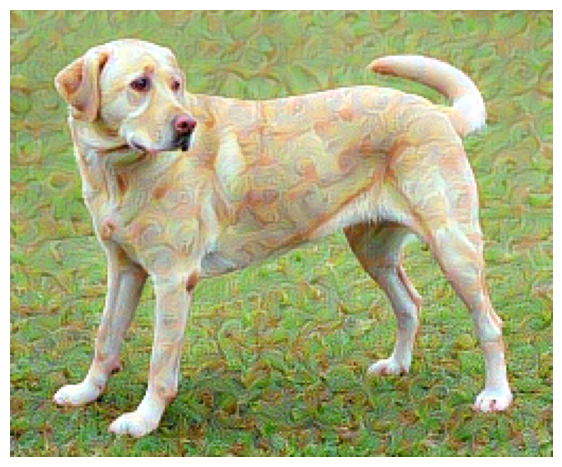

In [21]:
train_step(image)
train_step(image)
train_step(image)
img = tensor_to_image(image)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

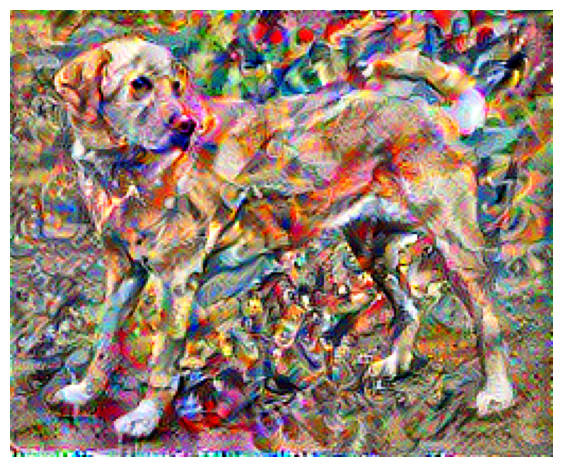

Epoch: 10, Train step: 1000, Loss: 12818116.0000
Total time: 23.3 sec


In [22]:
import time
from IPython import display

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(image)
        print(".", end='', flush=True)

    display.clear_output(wait=True)

    img = tensor_to_image(image)
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Epoch: {}, Train step: {}, Loss: {:.4f}".format(n+1, step, float(loss)))

end = time.time()
print("Total time: {:.1f} sec".format(end - start))

In [23]:
class Individual:
    def __init__(self, extractor, style_targets, content_targets, image_shape, content_image, style_image, code=None):
        if code is not None:
            self.code = code
        else:
            init_code = content_image
            self.code = tf.Variable(init_code + tf.random.normal(image_shape, stddev=0.05))
            self.code = tf.clip_by_value(self.code, 0.0, 1.0)

        self.extractor = extractor
        self.style_targets = style_targets
        self.content_image = content_image
        self.style_image = style_image
        self.content_targets = content_targets
        self.fitness = None
        self.calc_fitness()

    def calc_fitness(self):
        outputs = self.extractor(self.code)
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        style_loss = tf.add_n([
            tf.reduce_mean((style_outputs[name] - self.style_targets[name]) ** 2)
            for name in style_outputs.keys()
        ])

        content_loss = tf.add_n([
            tf.reduce_mean((content_outputs[name] - self.content_targets[name]) ** 2)
            for name in content_outputs.keys()
        ])

        style_weight=1e-2
        content_weight=1e4

        loss = style_weight * style_loss + content_weight * content_loss

        self.fitness = -loss.numpy()

    def mutate_with_gradient(self, step_size=0.3, mutation_rate=0.3):

        if tf.random.uniform([]) < mutation_rate:
            with tf.GradientTape() as tape:
                tape.watch(self.code)

                outputs = self.extractor(self.code)

                style_loss = tf.add_n([
                    tf.reduce_mean((outputs['style'][name] - self.style_targets[name]) ** 2)
                    for name in outputs['style'].keys()
                ])

                content_loss = tf.add_n([
                    tf.reduce_mean((outputs['content'][name] - self.content_targets[name]) ** 2)
                    for name in outputs['content'].keys()
                ])

                style_weight = 1e-2
                content_weight = 1e4

                total_loss = style_weight * style_loss + content_weight * content_loss

            grads = tape.gradient(total_loss, self.code)

            update = -step_size * grads
            new_code = self.code + update
            new_code = tf.clip_by_value(new_code, 0.0, 1.0)

            self.code.assign(new_code)
            self.calc_fitness()

    def clone(self):
        return Individual(
            extractor=self.extractor,
            style_targets=self.style_targets,
            content_targets=self.content_targets,
            image_shape=self.code.shape,
            content_image=self.content_image,
            style_image=self.style_image,
            code=tf.Variable(tf.identity(self.code))
        )

In [24]:
class GeneticAlgorithm:
    def __init__(self, extractor, style_targets, content_targets, image_shape,
                 content_image, style_image,
                 population_size=10, elitism_size=2,
                 tournament_size=3, mutation_rate=0.4):

        self.extractor = extractor
        self.style_targets = style_targets
        self.content_targets = content_targets
        self.image_shape = image_shape
        self.content_image = content_image
        self.style_image = style_image

        self.population_size = population_size
        self.elitism_size = elitism_size
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate

        self.population = [
            Individual(extractor, style_targets, content_targets, image_shape,
                       content_image=self.content_image, style_image=self.style_image)
            for _ in range(population_size)
        ]

    def selection(self, exclude=None):
        candidates = [c for c in self.population if c is not exclude]
        candidates = random.sample(candidates, self.tournament_size)
        return max(candidates, key=lambda x: x.fitness)

    def crossover(self, parent1, parent2):
        shape = parent1.code.shape
        batch, height, width, channels = shape

        split = tf.random.uniform([], 0, height, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((1, split, width, channels), dtype=tf.float32),
            tf.zeros((1, height - split, width, channels), dtype=tf.float32)
        ], axis=1)

        child1_tensor = parent1.code * mask + parent2.code * (1 - mask)
        child2_tensor = parent2.code * mask + parent1.code * (1 - mask)

        child1 = Individual(
            extractor=parent1.extractor,
            style_targets=parent1.style_targets,
            content_targets=parent1.content_targets,
            image_shape=shape,
            content_image=parent1.content_image,
            style_image=parent1.style_image,
            code=tf.Variable(child1_tensor)
        )

        child2 = Individual(
            extractor=parent1.extractor,
            style_targets=parent1.style_targets,
            content_targets=parent1.content_targets,
            image_shape=shape,
            content_image=parent1.content_image,
            style_image=parent1.style_image,
            code=tf.Variable(child2_tensor)
        )

        return child1, child2

    def mutation(self, individual, use_gradient=True):
        if use_gradient:
            individual.mutate_with_gradient(step_size=0.3, mutation_rate=self.mutation_rate)
            return individual
        else:
            if random.random() < 0.5:
                target = self.style_image
            else:
                target = self.content_image

            alpha = 0.1
            mutated_code = (1 - alpha) * individual.code + alpha * target
            mutated_code += tf.random.normal(self.image_shape, stddev=self.mutation_rate)
            mutated_code = tf.clip_by_value(mutated_code, 0.0, 1.0)

            return Individual(self.extractor, self.style_targets, self.content_targets,
                              self.image_shape,
                              content_image=self.content_image, style_image=self.style_image,
                              code=tf.Variable(mutated_code))

    def evolve(self, generations=10):
        population = self.population
        new_population = [None for _ in range(self.population_size)]

        if self.elitism_size % 2 != self.population_size % 2:
            self.elitism_size += 1

        best_fitnesses = []
        start_time = time.time()

        best_global = max(population, key=lambda x: x.fitness).clone()

        for gen in range(generations):
            population.sort(key=lambda x: x.fitness, reverse=True)
            best_individual = population[0]
            best_fitnesses.append(best_individual.fitness)

            if best_individual.fitness > best_global.fitness:
                best_global = best_individual.clone()

            print(f"\nGeneracija {gen + 1} | Najbolji fitness: {best_individual.fitness:.4f}")

            plt.figure(figsize=(5, 5))
            plt.imshow(tf.squeeze(best_individual.code))
            plt.title(f"Gen {gen+1} - Fitness: {best_individual.fitness:.2f}")
            plt.axis('off')
            plt.show()

            new_population[:self.elitism_size] = [ind.clone() for ind in population[:self.elitism_size]]

            for i in range(self.elitism_size, self.population_size, 2):
                parent1 = self.selection()
                parent2 = self.selection(exclude=parent1)

                child1, child2 = self.crossover(parent1, parent2)

                value = random.choice([True, False])

                child1 = self.mutation(child1, value)
                child2 = self.mutation(child2, value)

                new_population[i] = child1
                if i + 1 < self.population_size:
                    new_population[i + 1] = child2

            population = [ind.clone() for ind in new_population]

        total_time = time.time() - start_time
        print(f"\nUkupno vreme evolucije: {total_time:.2f} sekundi")

        plt.figure(figsize=(8, 4))
        plt.plot(best_fitnesses)
        plt.xlabel("Generacija")
        plt.ylabel("Najbolji fitness")
        plt.title("Napredak tokom evolucije")
        plt.grid(True)
        plt.show()

        return best_global

In [25]:
class GeneticAlgorithmHybrid(GeneticAlgorithm):
    def __init__(self, *args, local_steps=2, local_lr=0.005, **kwargs):
        super().__init__(*args, **kwargs)
        self.local_steps = local_steps
        self.local_lr = local_lr

    def local_search(self, individual):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.local_lr)

        for _ in range(self.local_steps):
            with tf.GradientTape() as tape:
                outputs = individual.extractor(individual.code)
                style_outputs = outputs['style']
                content_outputs = outputs['content']

                style_loss = tf.add_n([
                    tf.reduce_mean((style_outputs[name] - individual.style_targets[name]) ** 2)
                    for name in style_outputs.keys()
                ])

                content_loss = tf.add_n([
                    tf.reduce_mean((content_outputs[name] - individual.content_targets[name]) ** 2)
                    for name in content_outputs.keys()
                ])

                style_weight = 1e-2
                content_weight = 1e4
                loss = style_weight * style_loss + content_weight * content_loss

            grads = tape.gradient(loss, [individual.code])
            optimizer.apply_gradients([(grads[0], individual.code)])
            individual.code.assign(tf.clip_by_value(individual.code, 0.0, 1.0))

        individual.calc_fitness()
        return individual

    def evolve(self, generations=10, apply_local_to="elite"):
        """
        apply_local_to: "elite" | "all" | None
        - elite -> lokalna pretraga na najboljima
        - all -> na svima
        - None -> samo čisti GA
        """
        start_time = time.time()

        population = self.population
        new_population = [None for _ in range(self.population_size)]
        best_fitnesses = []
        best_global = max(population, key=lambda x: x.fitness).clone()

        for gen in range(generations):
            population.sort(key=lambda x: x.fitness, reverse=True)
            best_individual = population[0]
            best_fitnesses.append(best_individual.fitness)

            if best_individual.fitness > best_global.fitness:
                best_global = best_individual.clone()

            print(f"\nGeneracija {gen + 1} | Najbolji fitness: {best_individual.fitness:.4f}")

            plt.figure(figsize=(5, 5))
            plt.imshow(tf.squeeze(best_individual.code))
            plt.title(f"Gen {gen+1} - Fitness: {best_individual.fitness:.2f}")
            plt.axis('off')
            plt.show()

            new_population[:self.elitism_size] = [ind.clone() for ind in population[:self.elitism_size]]

            for i in range(self.elitism_size, self.population_size, 2):
                parent1 = self.selection()
                parent2 = self.selection(exclude=parent1)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population[i] = child1
                if i + 1 < self.population_size:
                    new_population[i + 1] = child2

            population = [ind.clone() for ind in new_population]

            if apply_local_to == "elite":
                for i in range(self.elitism_size):
                    population[i] = self.local_search(population[i])
            elif apply_local_to == "all":
                population = [self.local_search(ind) for ind in population]

        total_time = time.time() - start_time
        print(f"\nUkupno vreme evolucije: {total_time:.2f} sekundi")

        plt.figure(figsize=(8, 4))
        plt.plot(best_fitnesses)
        plt.xlabel("Generacija")
        plt.ylabel("Najbolji fitness")
        plt.title("Napredak tokom evolucije")
        plt.grid(True)
        plt.show()

        return best_global

In [26]:
target_shape = content_image.shape[1:3]

style_image_resized = tf.image.resize(style_image, target_shape)

ga_hybrid = GeneticAlgorithmHybrid(
    extractor=extractor,
    style_targets=extractor(style_image_resized)['style'],
    content_targets=extractor(content_image)['content'],
    image_shape=content_image.shape,
    content_image=content_image,
    style_image=style_image_resized,
    population_size=20,
    elitism_size=2,
    tournament_size=3,
    mutation_rate=0.4,
    local_steps=2,
    local_lr=0.002
)

In [ ]:
best_hybrid_elite = ga_hybrid.evolve(generations=50, apply_local_to="elite")

In [ ]:
best_hybrid_all = ga_hybrid.evolve(generations=50, apply_local_to="all")

In [ ]:
best_hybrid_none = ga_hybrid.evolve(generations=50, apply_local_to=None)

In [ ]:
target_shape = content_image.shape[1:3]

style_image_resized = tf.image.resize(style_image, target_shape)

ga_hybrid = GeneticAlgorithmHybrid(
    extractor=extractor,
    style_targets=extractor(style_image_resized)['style'],
    content_targets=extractor(content_image)['content'],
    image_shape=content_image.shape,
    content_image=content_image,
    style_image=style_image_resized,
    population_size=20,
    elitism_size=2,
    tournament_size=3,
    mutation_rate=0.4,
    local_steps=2,
    local_lr=0.2
)

In [ ]:
best_hybrid_elite = ga_hybrid.evolve(generations=50, apply_local_to="elite")

In [ ]:
best_hybrid_all = ga_hybrid.evolve(generations=50, apply_local_to="all")

In [ ]:
target_shape = content_image.shape[1:3]

style_image_resized = tf.image.resize(style_image, target_shape)

ga_hybrid = GeneticAlgorithmHybrid(
    extractor=extractor,
    style_targets=extractor(style_image_resized)['style'],
    content_targets=extractor(content_image)['content'],
    image_shape=content_image.shape,
    content_image=content_image,
    style_image=style_image_resized,
    population_size=20,
    elitism_size=2,
    tournament_size=3,
    mutation_rate=0.4,
    local_steps=2,
    local_lr=0.02
)

In [ ]:
best_hybrid_elite = ga_hybrid.evolve(generations=50, apply_local_to="elite")